# Probabilistic Time Series Forecasting with the AutoBNN Package

This notebook introduces the Tensorflow Probability AutoBNN package. It provides examples for forecasting with the Mauna Loa atmospheric CO2 dataset, using either learned or manually specified kernels.

We recommend using a [TPU runtime](https://colab.sandbox.google.com/notebooks/tpu.ipynb) for this colab.

## Imports

In [1]:
# !pip install autobnn

import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

from autobnn import estimators
from autobnn import operators
from autobnn import kernels
from autobnn import likelihoods
from autobnn import training_util

seed = jax.random.PRNGKey(0)

## Mauna Loa CO2 Data
The Mauna Loa atmospheric CO2 dataset is available for download from the Scripps Institute. We construct a Pandas dataframe with the monthly readings of CO2 concentration, holding out the final 10 years to forecast.

In [2]:
# The Mauna Loa data as taken from
# https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
# Data is provided by the Scripps Institution of Oceanography at UC San Diego under a CC BY license
# (https://creativecommons.org/licenses/by/4.0/).
co2_by_month = np.array('320.62,321.60,322.39,323.70,324.08,323.75,322.38,320.36,318.64,318.10,319.78,321.03,322.33,322.50,323.04,324.42,325.00,324.09,322.54,320.92,319.25,319.39,320.73,321.96,322.57,323.15,323.89,325.02,325.57,325.36,324.14,322.11,320.33,320.25,321.32,322.89,324.00,324.42,325.63,326.66,327.38,326.71,325.88,323.66,322.38,321.78,322.85,324.12,325.06,325.98,326.93,328.14,328.08,327.67,326.34,324.69,323.10,323.06,324.01,325.13,326.17,326.68,327.17,327.79,328.92,328.57,327.36,325.43,323.36,323.56,324.80,326.01,326.77,327.63,327.75,329.73,330.07,329.09,328.04,326.32,324.84,325.20,326.50,327.55,328.55,329.56,330.30,331.50,332.48,332.07,330.87,329.31,327.51,327.18,328.16,328.64,329.35,330.71,331.48,332.65,333.09,332.25,331.18,329.39,327.43,327.37,328.46,329.57,330.40,331.40,332.04,333.31,333.97,333.60,331.90,330.06,328.56,328.34,329.49,330.76,331.75,332.56,333.50,334.58,334.88,334.33,333.05,330.94,329.30,328.94,330.31,331.68,332.93,333.42,334.70,336.07,336.75,336.27,334.92,332.75,331.59,331.16,332.40,333.85,334.97,335.38,336.64,337.76,338.01,337.89,336.54,334.68,332.76,332.55,333.92,334.95,336.23,336.76,337.96,338.88,339.47,339.29,337.73,336.09,333.92,333.86,335.29,336.73,338.01,338.36,340.07,340.77,341.47,341.17,339.56,337.60,335.88,336.02,337.10,338.21,339.24,340.48,341.38,342.51,342.91,342.25,340.49,338.43,336.69,336.86,338.36,339.61,340.75,341.61,342.70,343.57,344.14,343.35,342.06,339.81,337.98,337.86,339.26,340.49,341.38,342.52,343.10,344.94,345.76,345.32,343.98,342.38,339.87,339.99,341.15,342.99,343.70,344.50,345.28,347.06,347.43,346.80,345.39,343.28,341.07,341.35,342.98,344.22,344.97,345.99,347.42,348.35,348.93,348.25,346.56,344.67,343.09,342.80,344.24,345.56,346.30,346.95,347.85,349.55,350.21,349.55,347.94,345.90,344.85,344.17,345.66,346.90,348.02,348.48,349.42,350.99,351.85,351.26,349.51,348.10,346.45,346.36,347.81,348.96,350.43,351.73,352.22,353.59,354.22,353.79,352.38,350.43,348.73,348.88,350.07,351.34,352.76,353.07,353.68,355.42,355.67,355.12,353.90,351.67,349.80,349.99,351.30,352.52,353.66,354.70,355.38,356.20,357.16,356.23,354.81,352.91,350.96,351.18,352.83,354.21,354.72,355.75,357.16,358.60,359.34,358.24,356.17,354.02,352.15,352.21,353.75,354.99,355.99,356.72,357.81,359.15,359.66,359.25,357.02,355.00,353.01,353.31,354.16,355.40,356.70,357.17,358.38,359.46,360.28,359.60,357.57,355.52,353.69,353.99,355.34,356.80,358.37,358.91,359.97,361.26,361.69,360.94,359.55,357.48,355.84,356.00,357.58,359.04,359.97,361.00,361.64,363.45,363.80,363.26,361.89,359.45,358.05,357.75,359.56,360.70,362.05,363.24,364.02,364.71,365.41,364.97,363.65,361.48,359.45,359.61,360.76,362.33,363.18,363.99,364.56,366.36,366.80,365.63,364.47,362.50,360.19,360.78,362.43,364.28,365.33,366.15,367.31,368.61,369.30,368.88,367.64,365.78,363.90,364.23,365.46,366.97,368.15,368.87,369.59,371.14,371.00,370.35,369.27,366.93,364.64,365.13,366.68,368.00,369.14,369.46,370.51,371.66,371.83,371.69,370.12,368.12,366.62,366.73,368.29,369.53,370.28,371.50,372.12,372.86,374.02,373.31,371.62,369.55,367.96,368.09,369.68,371.24,372.44,373.08,373.52,374.85,375.55,375.40,374.02,371.48,370.70,370.25,372.08,373.78,374.68,375.62,376.11,377.65,378.35,378.13,376.61,374.48,372.98,373.00,374.35,375.69,376.79,377.36,378.39,380.50,380.62,379.55,377.76,375.83,374.05,374.22,375.84,377.44,378.34,379.61,380.08,382.05,382.24,382.08,380.67,378.67,376.42,376.80,378.31,379.96,381.37,382.02,382.56,384.37,384.92,384.03,382.28,380.48,378.81,379.06,380.14,381.66,382.58,383.71,384.34,386.23,386.41,385.87,384.45,381.84,380.86,380.86,382.36,383.61,385.07,385.84,385.83,386.77,388.51,388.05,386.25,384.08,383.09,382.78,384.01,385.11,386.65,387.12,388.52,389.57,390.16,389.62,388.07,386.08,384.65,384.33,386.05,387.49,388.55,390.07,391.01,392.38,393.22,392.24,390.33,388.52,386.84,387.16,388.67,389.81,391.30,391.92,392.45,393.37,394.28,393.69,392.59,390.21,389.00,388.93,390.24,391.80,393.07,393.35,394.36,396.43,396.87,395.88,394.52,392.54,391.13,391.01,392.95,394.34,395.61,396.85,397.26,398.35,399.98,398.87,397.37,395.41,393.39,393.70,395.19,396.82,397.92,398.10,399.47,401.33,401.88,401.31,399.07,397.21,395.40,395.65,397.23,398.79,399.85,400.31,401.51,403.45,404.10,402.88,401.61,399.00,397.50,398.28,400.24,401.89,402.65,404.16,404.85,407.57,407.66,407.00,404.50,402.24,401.01,401.50,403.64,404.55,406.07,406.64,407.06,408.95,409.91,409.12,407.20,405.24,403.27,403.64,405.17,406.75,408.05,408.34,409.25,410.30,411.30,410.88,408.90,407.10,405.59,405.99,408.12,409.23,410.92'.split(',')).astype(np.float32)
num_forecast_steps = 12 * 10 # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]

co2_dates = np.arange("1966-01", "2019-02", dtype="datetime64[M]")

In [12]:
len(co2_by_month)

637

Text(0, 0.5, 'CO2 concentration / ppm')

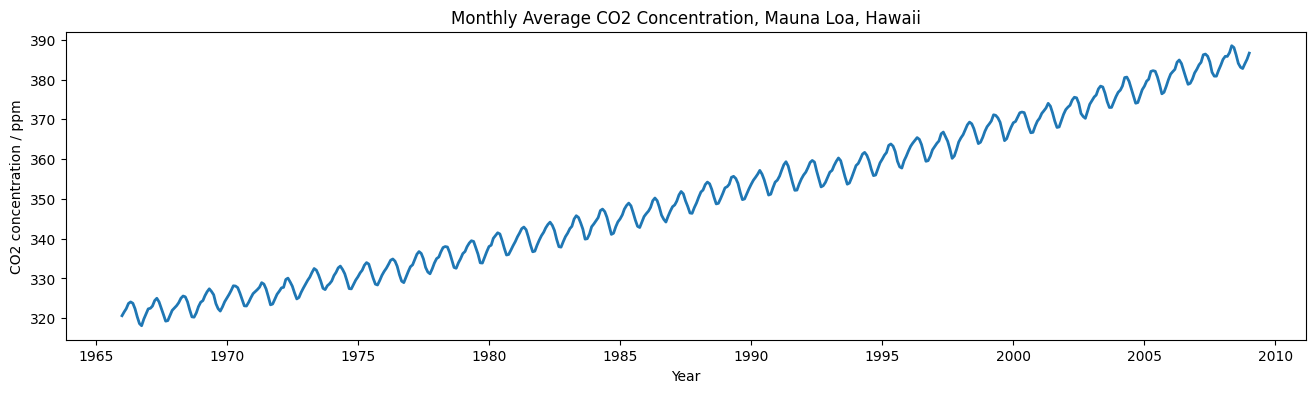

In [3]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(co2_dates[:-num_forecast_steps], co2_by_month_training_data, lw=2)
plt.title("Monthly Average CO2 Concentration, Mauna Loa, Hawaii")
plt.xlabel("Year")
plt.ylabel("CO2 concentration / ppm")

The data is passed to the fitting function as an array of time indices `x_train` (normalized to span the range of 0 to 1), which form the input to the neural network, and an array of target values `y_train` which the network predicts.

In [4]:
x_test = np.arange(len(co2_by_month), dtype=np.float32)
y_test = co2_by_month
x_train = x_test[:-num_forecast_steps]
y_train = co2_by_month_training_data

x_scale = x_train.max()
x_train = x_train / x_scale
x_test = x_test / x_scale

one_year = jnp.array(12. / x_scale, dtype=jnp.float32)  # monthly data

## Modeling with a hand-crafted GP kernel

This section explores applying the AutoBNN framework with a hand-crafted kernel, building upon the example in section 5.4.3 of [Rasmussen & Williams (2006)](https://gaussianprocess.org/gpml/chapters/RW5.pdf) for modeling the Mauna Loa atmospheric CO2 dataset. Their example aimed to showcase the power and flexibility of Gaussian Processes, and their chosen kernel serves as a valuable test case for our framework.

Rasmussen & Williams select the following components for their model:
* a squared exponential (SE) kernel to capture the smooth trend.
* a periodic kernel with a period of one year, multiplied with an SE to allow deviations from exact periodicity.
* a rational quadratic to model medium term irregularities.
* a squared exponential noise term.

The authors note that "one could also have used a squared exponential form for [the rational quadratic] component", which we do here as our framework does not currently implement the rational quadratic. The squared exponential noise term is provided by our Normal likelihood model.  With these translations, the Rasumussen & Williams model is easily specified in the following AutoBNN code:

In [5]:
smooth_trend = kernels.ExponentiatedQuadraticBNN(
    amplitude_scale=4., length_scale_scale=one_year * 4.)

# For annoying technical reasons, any kernels used in a Multiply operator
# must pass the going_to_be_multiplied=True option in their constructor.
# (This is because the Multiply operator doesn't use the final layer of
# weights from its input BNNs, and going_to_be_multiplied=True tells the
# BNN not to create them so that they are not allocated or optimized over.)
seasonal = operators.Multiply(bnns=[
    kernels.PeriodicBNN(period=one_year, going_to_be_multiplied=True),
    kernels.ExponentiatedQuadraticBNN(amplitude_scale=4.,
                                      length_scale_scale=one_year,
                                      going_to_be_multiplied=True)])

medium_term = kernels.ExponentiatedQuadraticBNN(length_scale_scale=one_year)

# To train a BNN, we must define a likelihood model that says how likely
# the observed data is given the BNN's predictions.  The
# NormalLikelihoodLogisticNoise likelihood model says that
# P(data | predictions) ~ N(mean=predictions, scale=n)
# with
# n ~ Logistic(location=0, scale=log_noise_scale)
likelihood = likelihoods.NormalLikelihoodLogisticNoise(log_noise_scale=0.1)

kernel = operators.WeightedSum(likelihood_model=likelihood,
                               bnns=[smooth_trend, medium_term, seasonal])



 We fit the model using a maximum a posteriori (MAP) estimate. We train an ensemble of 64 fits, which helps explore multiple modes of the posterior and results in better uncertainty than a single MAP fit.


In [6]:
# %%time
seed = jax.random.PRNGKey(0)
fit_seed, pred_seed, seed = jax.random.split(seed, 3)

params, loss = training_util.fit_bnn_map(
    kernel,
    seed=fit_seed,
    x_train=x_train[..., None],
    y_train=y_train[..., None],
    num_particles=32,
    # optimizer_kwargs:
    num_iters=2_000,
    learning_rate=0.01
    )

c:\Users\luisg\anaconda3\envs\autobnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualizing the Results of the hand-crafted model

After computing predictions on the held-out set, we use our visualization utilities to show loss curves and predictions. The loss curves serve mainly as a diagnostic to ensure all 64 particles converge to a low loss, and do not diverge or get stuck. The prediction plot shows ground truth data and the model fit. The fit shows both individual particles (gray) as well as the mean prediction with 5% and 95% confidence intervals (blue). The fit here captures the overall upwards trend and sawtooth shape of the periodic component.
After about 3 years of prediction intervals that contain the held out data, the model begins to underpredict, indicating that it did not quite capture the trend in the data, and is overly confident in this prediction.

While it's hard to compare directly with the results in Rasmussen & Williams (they fit on an earlier subset of the data and do not compare against a held-out set), we note that imperfections in our fit could be due to slight differences in the kernel specification. This serves as a reminder how difficult and error-prone kernel design can be.


Text(0, 0.5, 'CO2 concentration / ppm')

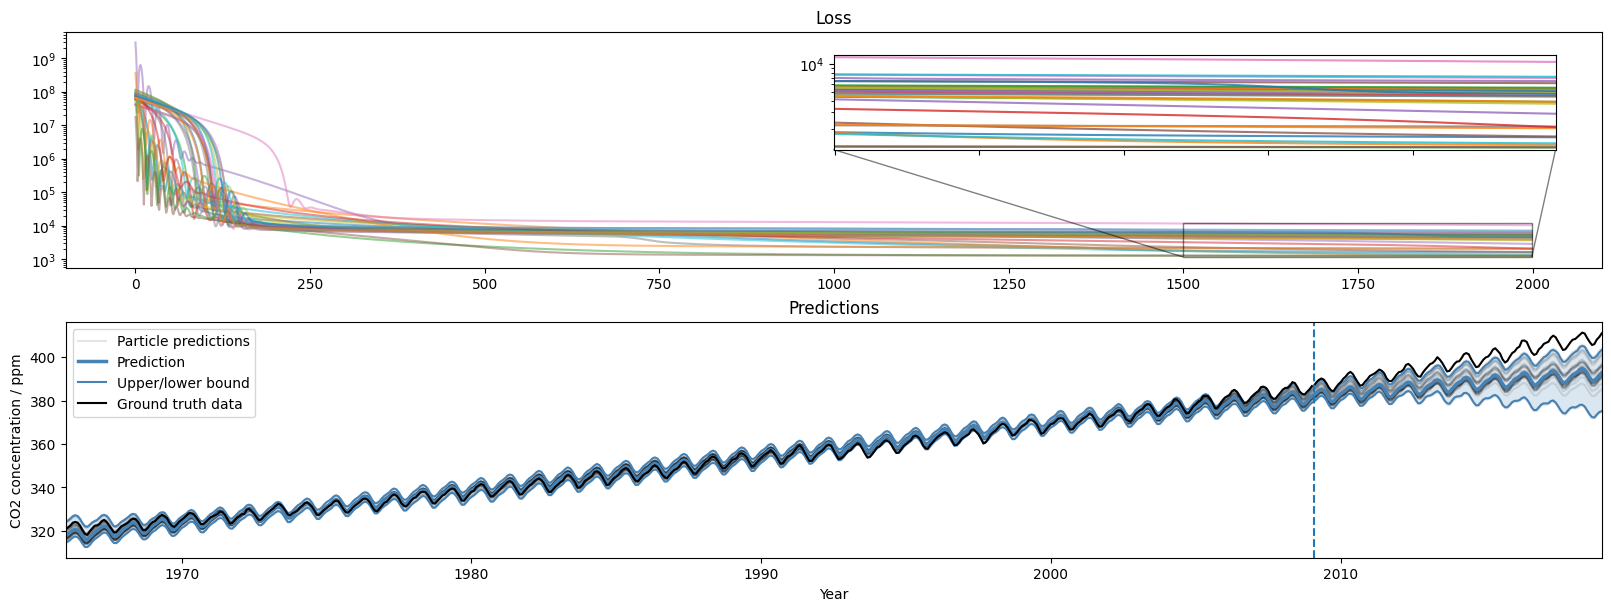

In [7]:
preds = jax.vmap(lambda p: kernel.apply(p, x_test[..., None]))(params)

draws = likelihood.sample(params['params'], preds.squeeze(), seed=pred_seed, sample_shape=100)
lo, mid, p90, hi = jnp.percentile(draws.squeeze(), jnp.array([2.5, 50., 90., 97.5]), axis=(0, 1))

plot = training_util.plot_results(co2_dates,
                               preds,
                               dates_test=co2_dates[-num_forecast_steps:],
                               y_test=co2_by_month[-num_forecast_steps:],
                               p2_5=lo,
                               p50=mid,
                               p97_5=hi,
                               dates_train=co2_dates[:-num_forecast_steps],
                               y_train=co2_by_month[:-num_forecast_steps],
                               diagnostics=loss,
                               log_scale=True,
                               show_particles=True,
                               left_limit=50*12,
                               right_limit=10*12)

plot.axes[1].set_xlabel("Year")
plot.axes[1].set_ylabel("CO2 concentration / ppm")

## Metrics

The `make_results_dataframe` provides SMAPE, MASE and MSIS, [common forecasting metrics](https://medium.com/@vinitkothari.24/time-series-evaluation-metrics-mape-vs-wmape-vs-smape-which-one-to-use-why-and-when-part1-32d3852b4779), for this fit. We compute metrics to 10 years out (specified by `num_forecast_steps`) and report the fit at 60 months (i.e. 5 years) out as an example.

In [8]:
training_util.make_results_dataframe(mid[-num_forecast_steps:],
                                     y_test=co2_by_month[-num_forecast_steps:],
                                     y_train=co2_by_month[:-num_forecast_steps],
                                     p2_5=lo[-num_forecast_steps:],
                                     p90=p90[-num_forecast_steps:],
                                     p97_5=hi[-num_forecast_steps:]
                                     ).iloc[60]

yhat          388.255554
yhat_lower    381.969391
p90           393.649689
yhat_upper    395.399506
y             398.100006
smape           1.895951
mase            4.828123
msis           51.246929
Name: 60, dtype: float64

## Structure Discovery with Continuous Relaxations

Manually specifying a kernel, like we did above, can be useful in many situations. The true power of the AutoBNN framework, though, lies in its ability to discover structure directly from the data. Below we run the same MAP estimator with the `sum_of_products` model, which is one of the model families distributed with the AutoBNN packages.

This kernel uses a continuous relaxation over periodic, linear, exponentiated quadratic, second-degree polynomial and identity leaves as the basic structure. It then combines four such subtrees by first adding them in pairs, and multiplying the final two subtrees. This is a structure that we empirically found to be suitable to model a wide variety of time series. It can serve as a useful starting point for further exploration.  Other model families supporting structure discovery can be found in the [models.py](https://github.com/tensorflow/probability/blob/main/spinoffs/autobnn/autobnn/models.py) file.

In [9]:
# %%time
fit_seed, pred_seed, seed = jax.random.split(seed, 3)

est = estimators.AutoBnnMapEstimator(
    'sum_of_products',
    likelihood_model='normal_likelihood_logistic_noise',
    seed=jax.random.PRNGKey(0),
    periods=(one_year,),
    num_particles=32,
)

est = est.fit(x_train[..., None], y_train[..., None])

## Visualizing the Results of the AutoBNN model

Compared to the hand-crafted kernel above, the prediction plot shows a  tighter fit to the training data, with a graceful increase in uncertainty deeper into the forecast horizon.

Text(24.000000000000007, 0.5, 'CO2 concentration / ppm')

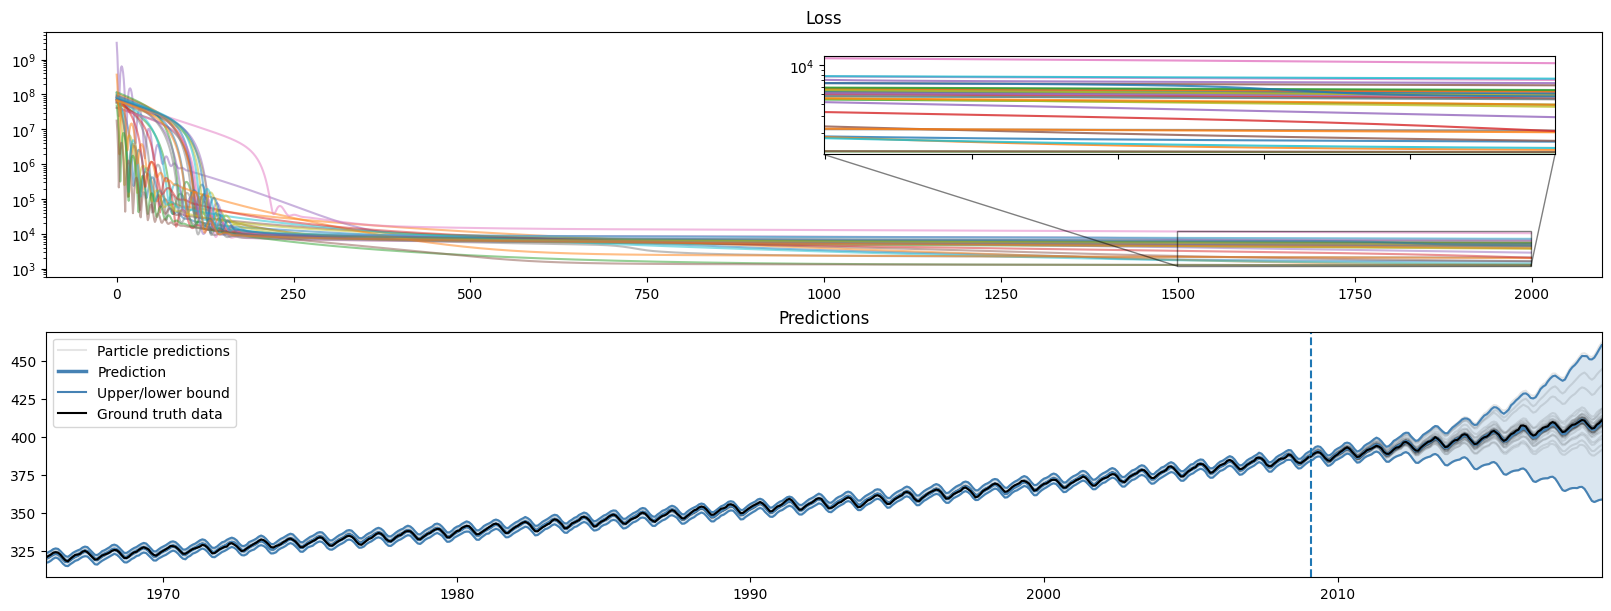

In [10]:
preds = est.predict(x_test[..., None])
lo, mid, p90, hi = est.predict_quantiles(x_test[..., None], q=[2.5, 50., 90., 97.5])
_ = training_util.plot_results(co2_dates,
                               preds,
                               dates_test=co2_dates[-num_forecast_steps:],
                               y_test=co2_by_month[-num_forecast_steps:],
                               p2_5=lo,
                               p50=mid,
                               p97_5=hi,
                               dates_train=co2_dates[:-num_forecast_steps],
                               y_train=co2_by_month[:-num_forecast_steps],
                               diagnostics=loss,
                               log_scale=True,
                               show_particles=True,
                               left_limit=50*12,
                               right_limit=10*12)
plot.axes[1].set_xlabel("Year")
plot.axes[1].set_ylabel("CO2 concentration / ppm")

In [11]:
training_util.make_results_dataframe(mid[-num_forecast_steps:],
                                     y_test=co2_by_month[-num_forecast_steps:],
                                     y_train=co2_by_month[:-num_forecast_steps],
                                     p2_5=lo[-num_forecast_steps:],
                                     p90=p90[-num_forecast_steps:],
                                     p97_5=hi[-num_forecast_steps:]
                                     ).iloc[60]


yhat          398.600647
yhat_lower    384.918701
p90           404.868744
yhat_upper    408.893921
y             398.100006
smape           0.073453
mase            0.188848
msis            7.687087
Name: 60, dtype: float64

## Conclusion

This colab showcases two applications of the AutoBNN framework to the Mauna Loa dataset, fitting a model with pre-defined structure and using structure discovery. While this dataset with about 500 time steps is well within reach for fitting a GP, we have successfuly run the same models with datasets of 5000 and more timesteps.